# 1. COMUNICACION DE RESULTADOS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

#Automcompletar rápido
%config IPCompleter.greedy=True

pd.options.display.max_columns = None

con = sa.create_engine('sqlite:///../08_2024_MADRID_DATOS/airbnbmadrid.db')

df = pd.read_sql('df_preparado', con = con)

#Minicubo precio:

metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc','number_of_reviews_disc']

minicubo_precio = df[dimensiones + metricas]

minicubo_precio = minicubo_precio.melt(id_vars=['precio_total','precio_compra'])

minicubo_precio = minicubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')

#Minicubo ocupacion:
df.loc[df.number_of_reviews_disc == '1-4', 'number_of_reviews_disc'] = '01-04'
df.loc[df.number_of_reviews_disc == '5-48', 'number_of_reviews_disc'] = '05-48'
metricas_ocupacion = ['ocupacion','precio_total']
dimensiones_ocupacion = ['bedrooms_disc','accommodates_disc','beds_disc','number_of_reviews_disc']

minicubo_ocupacion = df[dimensiones_ocupacion + metricas_ocupacion]

minicubo_ocupacion = minicubo_ocupacion.melt(id_vars=['ocupacion','precio_total'])

minicubo_ocupacion = minicubo_ocupacion.groupby(['variable','value'])[['ocupacion','precio_total']].agg('median')

In [2]:
con = sa.create_engine('sqlite:///../08_2024_MADRID_DATOS/airbnbmadrid.db')

df = pd.read_sql('df_preparado', con = con)

## 1.2. CONTEXTO DEL ANALISIS

La empresa ha seleccionado la ciudad de Madrid como candidata para buscar inmuebles en los que invertir con el objetivo de obtener rentabilidad mediante alquiler turístico.

Para ello, antes de poner al equipo de valoraciones a buscar oportunidades, la dirección ha encargado al equipo de Data Science un análisis de Discovery que permita identificar estrategias o líneas de trabajo que ayuden a dirigir la actuación del equipo de valoraciones.

Las palancas que influyen sobre el objetivo de negocio son:

* **Precio alquiler:** cuanto más se pueda cobrar por noche mayor es la rentabilidad
* **Ocupación:** en general cuantos más días al año se pueda alquilar un inmueble mayor es su rentabilidad
* **Precio inmueble:** cuanto más barato se pueda adquirir la propiedad mayor es la rentabilidad

Los KPIs son:

* Mediremos la ocupación como el número de días anuales que el inmueble se pueda alquilar
* Mediremos el precio del alquiler como el precio por noche en euros según Airbnb
* Mediremos el precio de un inmueble como la multiplicación entre el número de metros cuadrados y el precio medio del m2 en su zona

## 1.3. OBJETIVOS

* Analizar las fuentes de datos públicas disponibles 
* Para encontrar insights que ayuden a entender las características del mercado en esta ciudad
* Y guíen el trabajo de búsqueda del equipo de valoraciones
* Especialmente en cuanto a los principales ejes: precio del alquiler, niveles de ocupación y precio de compra

## 1.4. CONCLUSIONES EJECUTIVAS

* Se han localizado 8 barrios en los que centrar la búsqueda
* Se recomienda buscar inmuebles con un habitación que permitan alojar 3 huéspedes
* Se recomienda buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés
* Se recomienda incrementar el número de reseñas del inmueble en alquiler, ya que favorece a un incremento de la ocupación del mismo.
* Se recomienda evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo, especialmente en el barrio de San Blas

## 1.5. DETALLE DE LOS PRINCIPALES RESULTADOS

### 1.5.1. Existen 8 barrios con alto potencial de inversión

* Se han localizado 8 barrios que apriori pueden maximizar la relación coste-ingresos
* Además podemos segmentarlos por el tipo calidad del inmueble en el que nos interes invertir en 4 grandes grupos
* Estos son los 8 barrios donde comenzar a buscar oportunidades concretas:
* Inversión baja: Los Angeles
* Inversión media: Costillares, El Pardo, El Goloso
* Inversión media-alta: El Viso, Sol, Trafalgar
* Inversión alta: Recoletos

Exhibit 1.5.1

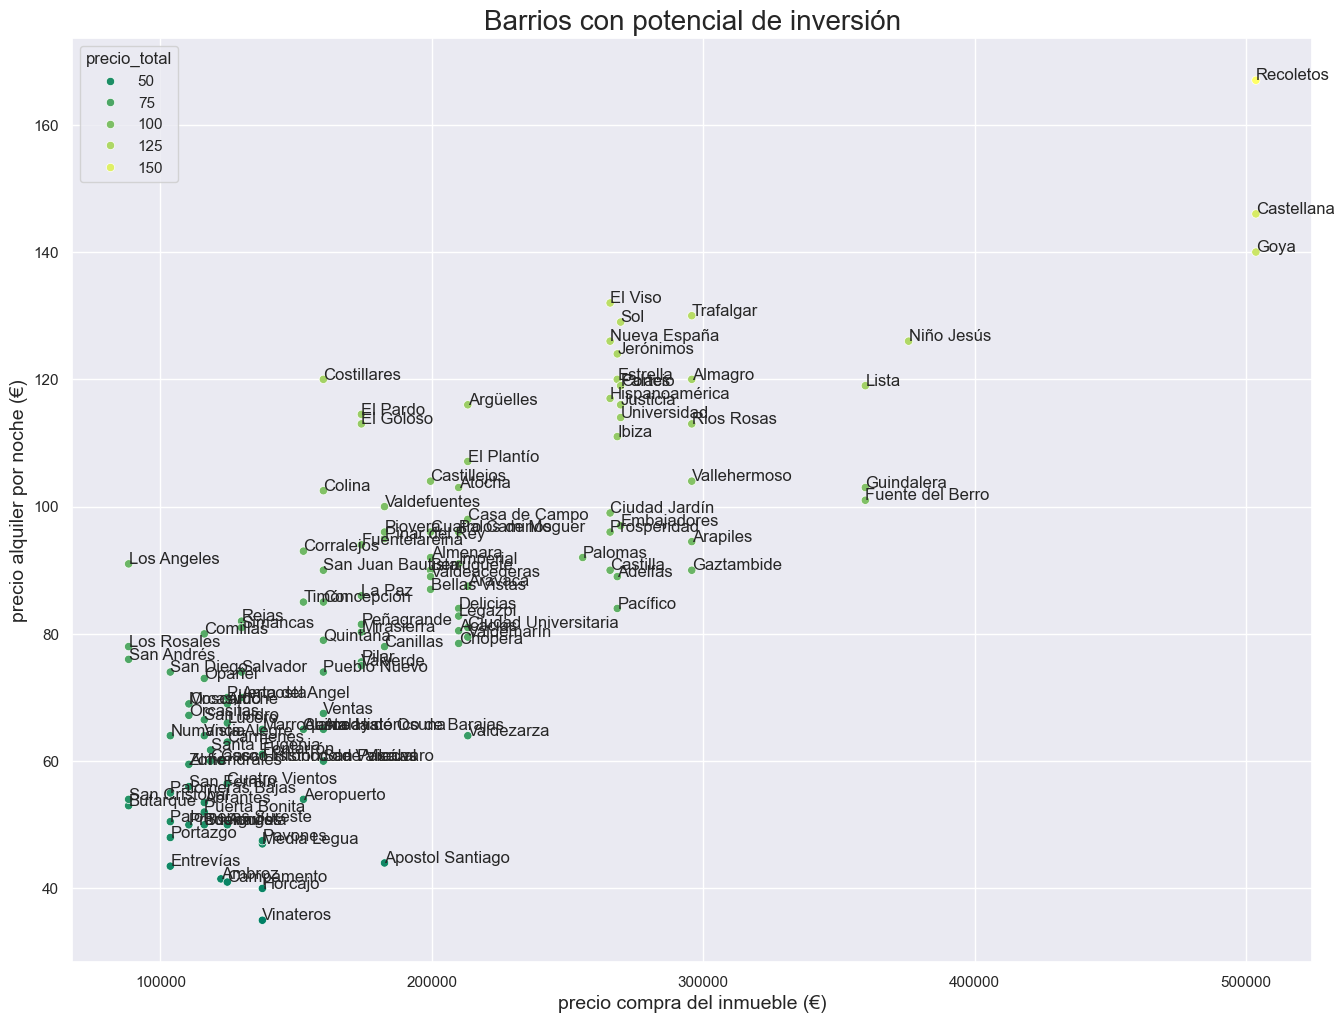

In [13]:
no_incluir = ['Rosas','Arcos','Canillejas','Hellín']

temp = df.groupby('neighbourhood')[['precio_total','precio_compra']].median()

temp = temp[~temp.index.isin(no_incluir)]

plt.figure(figsize = (16,12))
plt.title('Barrios con potencial de inversión', fontsize = 20)
plt.xlabel('precio compra del inmueble (€)', fontsize = 14)
plt.ylabel('precio alquiler por noche (€)', fontsize = 14);
sns.set_style('darkgrid')
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total',hue = 'precio_total', palette = 'summer')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

### 1.5.2. Buscar inmuebles de una habitación que permitan 3 huéspedes

El número de huéspedes que maximiza el precio de compra pagado es de 3

Exhibit 1.5.2

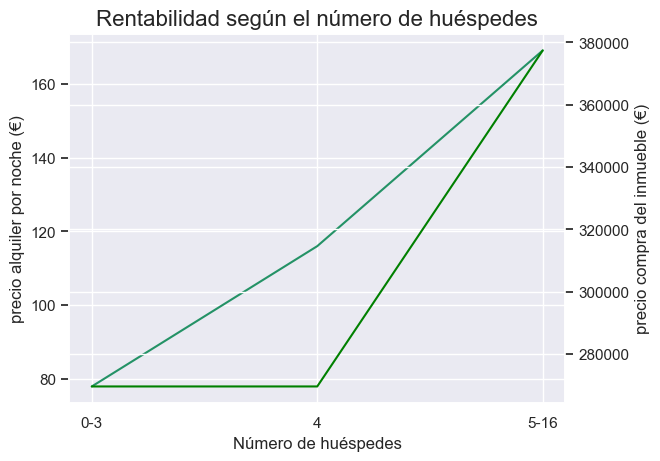

In [16]:
f, ax = plt.subplots()
ax.plot(minicubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(minicubo_precio.loc['accommodates_disc'].precio_compra,color = 'green');

ax.set_title('Rentabilidad según el número de huéspedes',fontsize = 16)
ax.set_xlabel('Número de huéspedes')
ax2.set_ylabel('precio compra del inmueble (€)')
ax.set_ylabel('precio alquiler por noche (€)');

### 1.5.3. Buscar inmuebles que estando en uno de los barrios identificados no estén necesariamente cerca de puntos de interés

* Previsiblemente tendrán menor precio de compra
* Parece que la cercanía a puntos de interés no tiene un especial impacto sobre el precio del alquiler

Exhibit 1.5.3

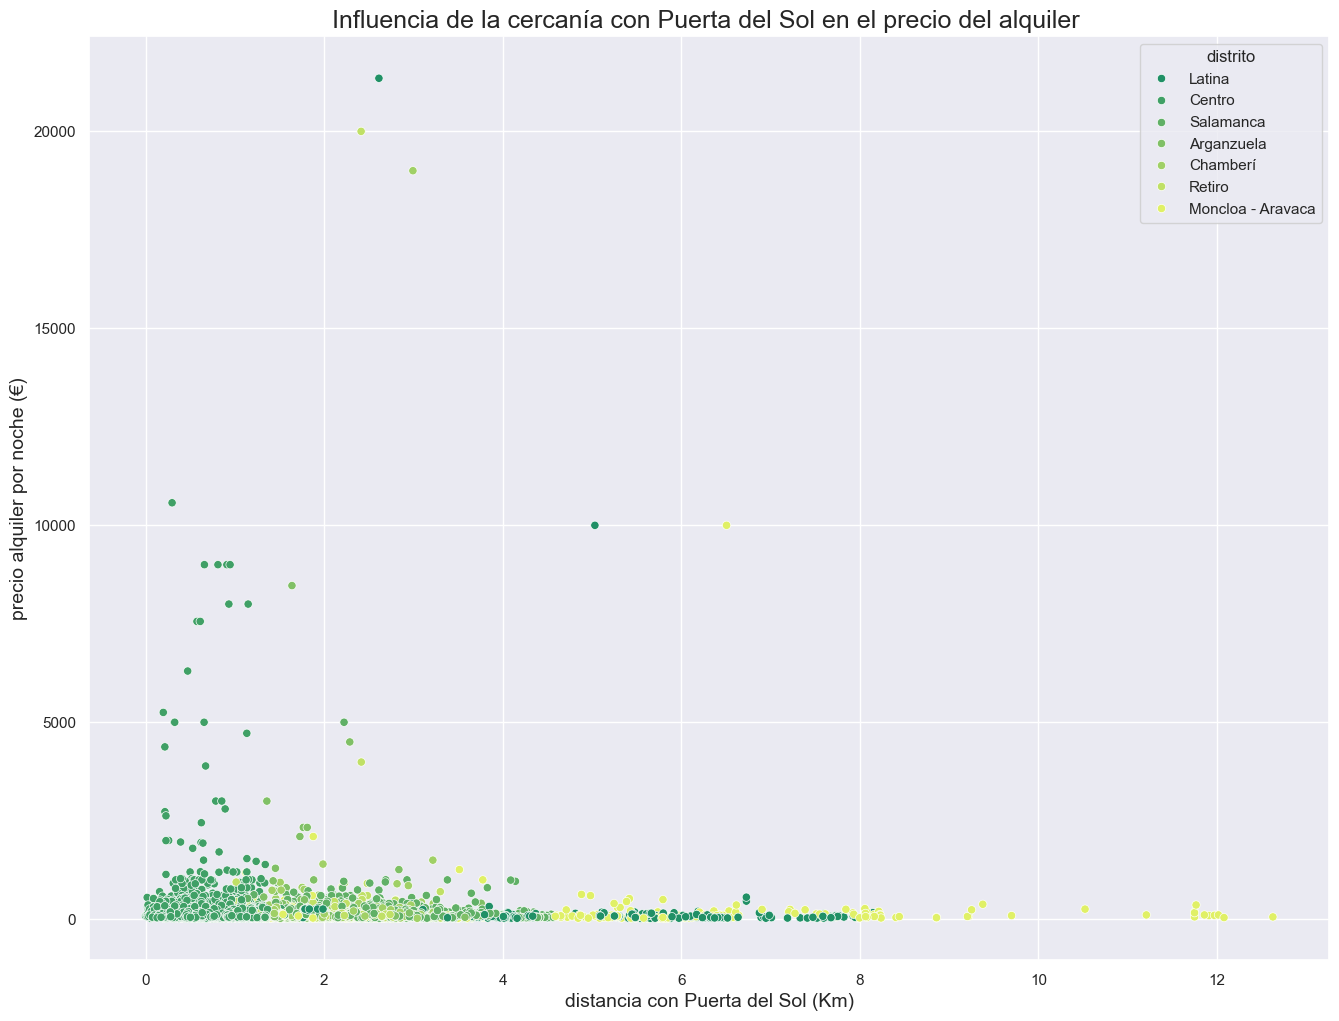

In [18]:
seleccion = df.groupby('distrito').pdi_sol.median().sort_values()[0:7].index.to_list()

plt.figure(figsize = (16,12))
sns.scatterplot(data = df.loc[df.distrito.isin(seleccion)], x = 'pdi_sol', y = 'precio_total',hue = 'distrito', palette = 'summer');
plt.title('Influencia de la cercanía con Puerta del Sol en el precio del alquiler ', fontsize = 18)
plt.xlabel('distancia con Puerta del Sol (Km)', fontsize = 14)
plt.ylabel('precio alquiler por noche (€)', fontsize = 14);

### 1.5.4. Incrementar el número de reseñas del inmueble en alquiler.

Las reseñas incrementan el % de ocupación de un inmueble.

Exhibit 1.5.4

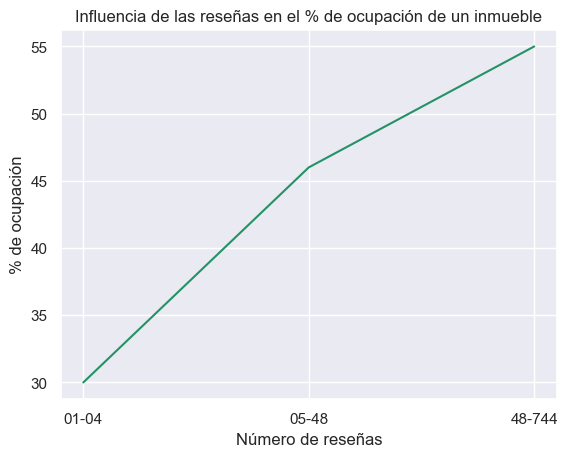

In [52]:
f, ax = plt.subplots()
ax.plot(minicubo_ocupacion.loc['number_of_reviews_disc'].ocupacion);

ax.set_title('Influencia de las reseñas en el % de ocupación de un inmueble')
ax.set_xlabel('Número de reseñas')
ax.set_ylabel('% de ocupación');

### 1.5.5. Evaluar el desarrollo de un nuevo producto basado en el alquier para momentos concretos de alto interés deportivo

* Buscar oportunidades en el distrito de San Blas
* Todavía existen muchos alquileres que no están explotando este potencial

Exhibit 1.5.5

<Figure size 1800x1800 with 0 Axes>

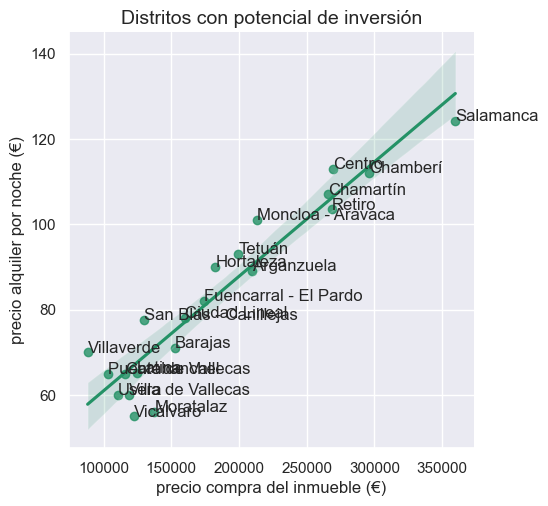

In [25]:
temp = df.groupby('distrito')[['precio_total','precio_compra']].median()

plt.figure(figsize = (18,18))
sns.lmplot(data = temp, x = 'precio_compra', y = 'precio_total')
plt.title('Distritos con potencial de inversión', fontsize = 14)
plt.xlabel('precio compra del inmueble (€)', fontsize = 12)
plt.ylabel('precio alquiler por noche (€)', fontsize = 12);
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

In [44]:
import folium

datos = df[df.distrito == 'San Blas - Canillejas'].copy()

datos['precio_total_disc'] = pd.qcut(datos['precio_total'], q = [0, .25, .5, .75, 1.], 
                              labels=['yellow', 'orange', 'blue', 'red'])

mapa = folium.Map(location=[datos.iloc[0,7], datos.iloc[0,8]],zoom_start=14)

for piso in range(0,len(datos)):
   folium.CircleMarker(
      location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
      popup = datos.iloc[piso]['precio_total'],
      fill=True,
      color = datos.iloc[piso]['precio_total_disc'],
      fill_opacity=1,
      radius = 5
   ).add_to(mapa)

mapa